# Impartus Question

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load data & tokenizer
print("Loading dataset and tokenizer...")
ds = load_dataset("imdb")
tok = BertTokenizer.from_pretrained("bert-base-uncased")

# Preprocessing function
def preprocess_function(examples):
    return tok(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply preprocessing
print("Preprocessing data...")
ds = ds.map(preprocess_function, batched=True)

# Set format to PyTorch tensors
ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Create DataLoaders with proper collate_fn
train_dataloader = DataLoader(ds["train"], batch_size=8, shuffle=True)
test_dataloader = DataLoader(ds["test"], batch_size=8)

# Load model
print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 1

# Training loop
print("Starting training...")
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Extract labels before passing inputs to model
        labels = batch.pop("label")
        
        # Forward pass
        outputs = model(**batch, labels=labels)
        loss = outputs.loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        
        # Print progress every 100 steps
        if step % 100 == 0 and step > 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Step {step}/{len(train_dataloader)} | Loss: {total_loss/step:.4f}")
        print("breaking it.. using break")
        break

# Evaluation
print("Evaluating model...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Extract labels before passing inputs to model
        labels = batch.pop("label")
        
        outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        
        all_preds.extend(predictions.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Loading dataset and tokenizer...
Preprocessing data...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Starting training...
Epoch 1/1 | Step 10/3125 | Loss: 0.7614
breaking it.. using break
Evaluating model...
Accuracy: 0.5779
Confusion Matrix:
[[ 2324 10176]
 [  377 12123]]


<Axes: >

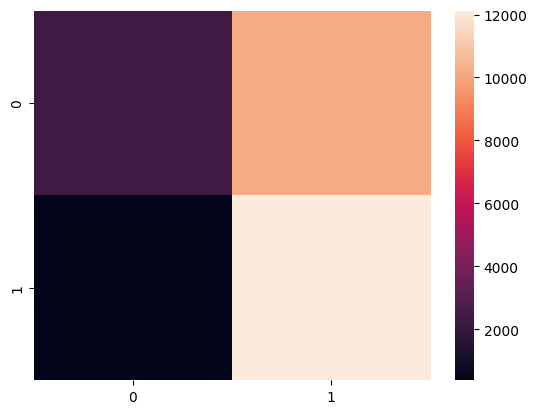

In [7]:
import seaborn as sns

sns.heatmap(conf_matrix)

In [25]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForQuestionAnswering

# Create DataFrame
df = pd.DataFrame({
    'Name': ['Alice', 'Bob'],
    'Age': [20, 22],
    'Course': ['Math', 'Physics'],
    'Marks': [85, 90],
    'Grade': ['A', 'A+']
})

# Convert DataFrame to natural language context
context = " ".join([
    f"{row['Name']} is {row['Age']} years old, enrolled in {row['Course']}, "
    f"scored {row['Marks']} marks, and has grade {row['Grade']}."
    for _, row in df.iterrows()
])

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Question Answering
question = "How old is Alice?"
inputs = tokenizer.encode_plus(question, context, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    start = torch.argmax(outputs.start_logits)
    end = torch.argmax(outputs.end_logits) + 1
    answer = tokenizer.decode(inputs["input_ids"][0, start:end])

print(f"Question: {question}\nAnswer: {answer}")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: How old is Alice?
Answer: 20 years old
